<a href="https://colab.research.google.com/github/RavinduP/Product_Success/blob/Recommendation_System/final_discount.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Missing values before preprocessing:
 Series([], dtype: int64)

Best Hyperparameters:
{'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Model Performance Metrics:
Mean Squared Error: 25.375518071034815
R^2 Score: 0.90550220745617

Top 10 Feature Importance with Standard Deviation:
                     Feature  Importance       Std
8               Campaign_Yes    0.309065  0.344680
11         Campaign Type_No     0.213650  0.280929
10        Campaign Type_Mega    0.105668  0.207468
5     Sales Revenue - Online    0.084537  0.169359
7                  Ad Budget    0.066027  0.122142
1   Sales Revenue - Physical    0.054197  0.100964
6    Sales Quantity - Online    0.046847  0.092380
3            Online visitors    0.042715  0.083465
4                 Page Views    0.040645  0.093548
2   Sales Quatity - Physical    0.027920  0.051764
Cross-validation scores: [ -12.95953805   -8.35838338  -23.42722082 -115.61104264  -71.74385759]


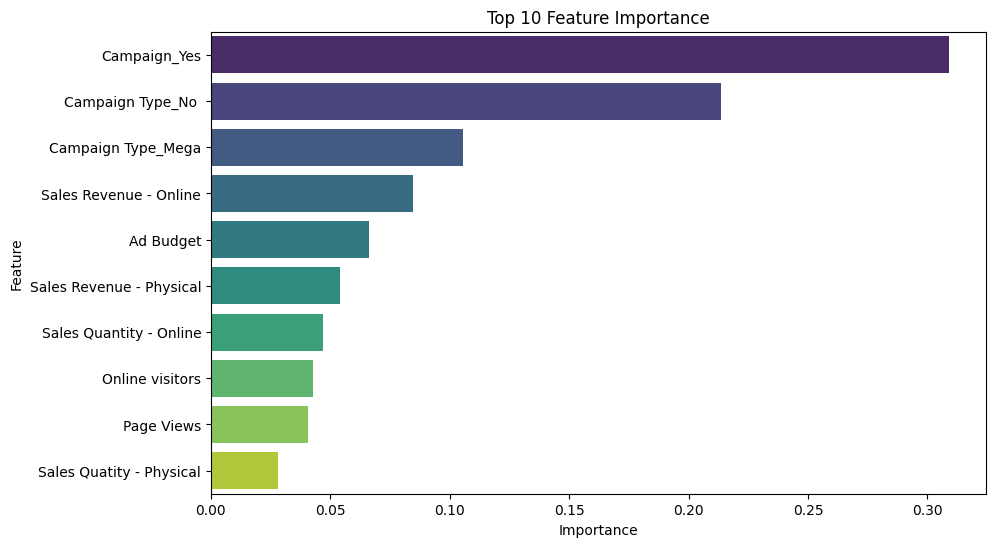

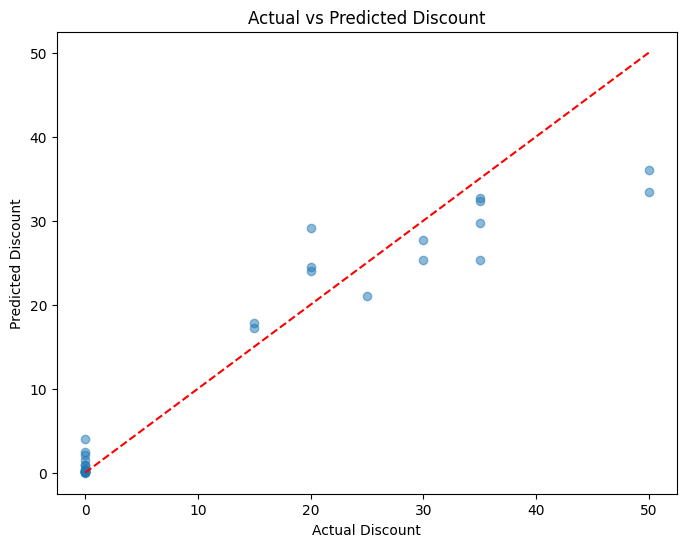

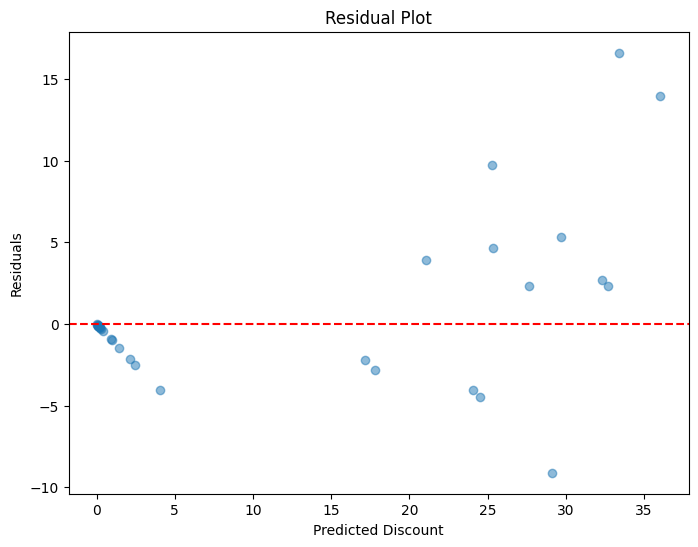

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
data_path = 'final_data.csv'
data = pd.read_csv(data_path)

# Clean numeric columns
def clean_numeric_column(column):
    return pd.to_numeric(column.replace({',': '', '%': ''}, regex=True), errors='coerce')

numeric_columns = [
    "Sales Revenue - Physical", "Online visitors", "Page Views", "Sales Revenue - Online",
    "Conversion", "Reach", "Impressions", "Clicks", "Influencer Campaign Reach",
    "Ad Budget", "Discount"
]

for col in numeric_columns:
    if col in data.columns:
        data[col] = clean_numeric_column(data[col])

# Fix column name issue
data.rename(columns={'Discount ': 'Discount'}, inplace=True)

# Handle missing values
for col in numeric_columns:
    if col in data.columns:
        data[col] = data[col].fillna(data[col].median())

data.dropna(subset=["Ad Type", "Campaign Type"], inplace=True)

# Drop unnecessary features
features_to_drop = [
    'Year', 'Conversion', 'Ad Type', 'Impressions', 'Clicks', 'Reach', 'Influencer Campaign Reach'
]

data_reduced = data.drop(features_to_drop, axis=1)

# Encode categorical features
encoder = OneHotEncoder(drop='first', sparse_output=False)
categorical_columns = ["Campaign", "Campaign Type"]
encoded_cats = encoder.fit_transform(data_reduced[categorical_columns])
encoded_cat_columns = encoder.get_feature_names_out(categorical_columns)
data_reduced = data_reduced.drop(categorical_columns, axis=1)
data_reduced[encoded_cat_columns] = encoded_cats

# Convert 'Month' to numeric and handle missing values
data_reduced['Month'] = pd.to_numeric(data_reduced['Month'], errors='coerce')

# Handle missing values in 'Month' column
if data_reduced['Month'].mode().empty:
    data_reduced['Month'] = data_reduced['Month'].fillna(1)
else:
    data_reduced['Month'] = data_reduced['Month'].fillna(data_reduced['Month'].mode().iloc[0])

# Define features and target
X = data_reduced.drop(["Discount"], axis=1)
y = data_reduced["Discount"]

# Check for missing values in X
missing_values = X.isna().sum()
print("Missing values before preprocessing:\n", missing_values[missing_values > 0])

# Fill missing values with column medians
X = X.fillna(X.median(numeric_only=True))

# Drop any remaining rows with missing values
X.dropna(inplace=True)
y = y[:len(X)]

# Add feature scaling
scaler = StandardScaler()
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
X[numeric_features] = scaler.fit_transform(X[numeric_features])

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42
)

# Updated Hyperparameter Grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [2, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Use more folds in cross-validation
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,  # Increased number of folds
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Train model
grid_search.fit(X_train, y_train)

# Get best model
best_model = grid_search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)

# Calculate and print results
print("\nBest Hyperparameters:")
print(grid_search.best_params_)

print("\nModel Performance Metrics:")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred)}")
print(f"R^2 Score: {r2_score(y_test, y_pred)}")

# Calculate feature importance with uncertainty
importances = best_model.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in best_model.estimators_
], axis=0)

feature_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances,
    "Std": std
}).sort_values(by="Importance", ascending=False)

print("\nTop 10 Feature Importance with Standard Deviation:")
print(feature_importance_df.head(10))

# Perform cross-validation on the best model
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

# Visualization Functions

# 1. Feature Importance Bar Plot
def plot_feature_importance(feature_importance_df):
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Importance", y="Feature", data=feature_importance_df.head(10), palette="viridis", hue="Feature", legend=False)
    plt.title("Top 10 Feature Importance")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()

# 2. Actual vs Predicted Discount Scatter Plot
def plot_actual_vs_predicted(y_true, y_pred):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--')
    plt.title("Actual vs Predicted Discount")
    plt.xlabel("Actual Discount")
    plt.ylabel("Predicted Discount")
    plt.show()

# 3. Residual Plot
def plot_residuals(y_true, y_pred):
    residuals = y_true - y_pred
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title("Residual Plot")
    plt.xlabel("Predicted Discount")
    plt.ylabel("Residuals")
    plt.show()

# Plot Feature Importance
plot_feature_importance(feature_importance_df)

# Plot Actual vs Predicted Discount
plot_actual_vs_predicted(y_test, y_pred)

# Plot Residuals
plot_residuals(y_test, y_pred)